# **Montage Drive**


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install pyspark

# **Import Libraries**

In [86]:
from pyspark.sql.functions import col, avg, sum,count,round,dayofweek, desc, when
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.window import Window
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# **Init SparkSession**

In [38]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

https://drive.google.com/file/d/1uzIrvqLTBSYrcB2XmJZD7bbdNjuAvFY_/view?usp=sharing


# **Chargement CSV**

In [39]:
flights_df = spark.read.csv('/content/drive/My Drive/ESGI/projet/flights.csv', header=True)
airlines_df=spark.read.csv('/content/drive/My Drive/ESGI/projet/airlines.csv', header=True)
airports_df=spark.read.csv('/content/drive/My Drive/ESGI/projet/airports.csv', header=True)

**Afficher 10 lignes**

In [40]:
 flights_df.show(10)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

# Data Prep


**Casting et nettoyage**


In [41]:
# flights
cols_to_cast = [
    "DEPARTURE_DELAY", "TAXI_OUT", "ELAPSED_TIME", "AIR_TIME",
    "DISTANCE", "TAXI_IN", "ARRIVAL_DELAY",
    "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]

flights_df = flights_df.select(*[
    col(c).cast(IntegerType()) if c in cols_to_cast else col(c)
    for c in flights_df.columns
])


#airports
cols_to_cast_airports = ["LATITUDE", "LONGITUDE"]
airports_df = airports_df.select(*[
    col(c).cast(FloatType()) if c in cols_to_cast_airports else col(c)
    for c in airports_df.columns
]).dropna(subset=["IATA_CODE"]).dropDuplicates(["IATA_CODE"])

#Suppression Douplon Airlines
airlines_df = airlines_df.dropna(subset=["IATA_CODE", "AIRLINE"]).dropDuplicates(["IATA_CODE"])

# Analytics

**Retards moyens par compagnie**

In [62]:
from pyspark.sql.functions import avg

avg_delay_by_airline = flights_df.groupBy("AIRLINE").agg(
    round(avg("DEPARTURE_DELAY"), 2).alias("AVG_DEPARTURE_DELAY"),
    round(avg("ARRIVAL_DELAY"), 2).alias("AVG_ARRIVAL_DELAY")
)
avg_df = avg_delay_by_airline.alias("avg")
airlines_df_alias = airlines_df.alias("air")

joined_df = avg_df.join(
    airlines_df_alias,
    avg_df["AIRLINE"] == airlines_df_alias["IATA_CODE"],
    "left"
)

result_df = joined_df.select(
    avg_df["AIRLINE"].alias("AIRLINE_CODE"),
    airlines_df_alias["AIRLINE"].alias("AIRLINE_NAME"),
    avg_df["AVG_DEPARTURE_DELAY"],
    avg_df["AVG_ARRIVAL_DELAY"]
).orderBy("AVG_ARRIVAL_DELAY", ascending=False)


result_df.show(30)


+------------+--------------------+-------------------+-----------------+
|AIRLINE_CODE|        AIRLINE_NAME|AVG_DEPARTURE_DELAY|AVG_ARRIVAL_DELAY|
+------------+--------------------+-------------------+-----------------+
|          NK|    Spirit Air Lines|              15.94|            14.47|
|          F9|Frontier Airlines...|              13.35|             12.5|
|          B6|     JetBlue Airways|              11.51|             6.68|
|          EV|Atlantic Southeas...|               8.72|             6.59|
|          MQ|American Eagle Ai...|              10.13|             6.46|
|          OO|Skywest Airlines ...|                7.8|             5.85|
|          UA|United Air Lines ...|              14.44|             5.43|
|          VX|      Virgin America|               9.02|             4.74|
|          WN|Southwest Airline...|              10.58|             4.37|
|          US|     US Airways Inc.|               6.14|             3.71|
|          AA|American Airlines...|   

**Graphique retards à l’arrivée**

In [43]:
pdf = result_df.toPandas()

fig = px.bar(
    pdf,
    x='AIRLINE_NAME',
    y='AVG_ARRIVAL_DELAY',
    labels={'AIRLINE_NAME': 'Compagnie aérienne', 'AVG_ARRIVAL_DELAY': 'Retard moyen à l\'arrivée (minutes)'},
    title='Retard moyen à l\'arrivée par compagnie aérienne',
    text=pdf['AVG_ARRIVAL_DELAY'].round(2)
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(title='Retard moyen (min)'), uniformtext_minsize=8)
fig.show()

**Graphique retards au départ**

In [44]:
pdf = result_df.toPandas()

fig = px.bar(
    pdf,
    x='AIRLINE_NAME',
    y='AVG_DEPARTURE_DELAY',
    labels={'AIRLINE_NAME': 'Compagnie aérienne', 'AVG_DEPARTURE_DELAY': 'Retard moyen à l\'arrivée (minutes)'},
    title='Retard moyen au départ par compagnie aérienne',
    text=pdf['AVG_DEPARTURE_DELAY'].round(2)
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(title='Retard moyen (min)'), uniformtext_minsize=8)
fig.show()

**Nombre de vols en retard par compagnie**


In [66]:
delay_count_by_airline = flights_df.filter(col("ARRIVAL_DELAY") > 0) \
    .groupBy("AIRLINE") \
    .agg(_sum((col("ARRIVAL_DELAY") > 0).cast("int")).alias("DELAYED_COUNT"))

delay_df = delay_count_by_airline.alias("delay")
airlines_df_alias = airlines_df.alias("air")

joined_delay_df = delay_df.join(
    airlines_df_alias,
    delay_df["AIRLINE"] == airlines_df_alias["IATA_CODE"],
    "left"
)

final_delay_df = joined_delay_df.select(
    delay_df["AIRLINE"].alias("AIRLINE_CODE"),
    airlines_df_alias["AIRLINE"].alias("AIRLINE_NAME"),
    delay_df["DELAYED_COUNT"]
).orderBy("DELAYED_COUNT", ascending=False)


**Barres horizontales retards**

In [67]:
plot_df = final_delay_df.toPandas()

fig = px.bar(
    plot_df,
    x="DELAYED_COUNT",
    y="AIRLINE_NAME",
    orientation="h",
    title="Nombre de vols en retard par compagnie",
    labels={"AIRLINE_NAME": "Compagnie", "DELAYED_COUNT": "Nombre de retards"}
)

fig.show()


**Nombre de vols déviés par compagnie**

In [47]:
from pyspark.sql.functions import col, sum as _sum

diverted_count_df = flights_df.filter(col("DIVERTED") == 1) \
    .groupBy("AIRLINE") \
    .agg(_sum((col("DIVERTED") == 1).cast("int")).alias("DIVERTED_COUNT"))

div_df = diverted_count_df.alias("div")
airlines_df_alias = airlines_df.alias("air")

joined_diverted_df = div_df.join(
    airlines_df_alias,
    div_df["AIRLINE"] == airlines_df_alias["IATA_CODE"],
    "left"
)

final_diverted_df = joined_diverted_df.select(
    div_df["AIRLINE"].alias("AIRLINE_CODE"),
    airlines_df_alias["AIRLINE"].alias("AIRLINE_NAME"),
    div_df["DIVERTED_COUNT"]
).orderBy("DIVERTED_COUNT", ascending=False)


**Barres horizontales vols déroutés**

In [48]:
plot_df = final_diverted_df.toPandas()

fig = px.bar(
    plot_df,
    x="DIVERTED_COUNT",
    y="AIRLINE_NAME",
    orientation="h",
    title="Nombre de vols déroutés par compagnie",
    labels={"AIRLINE_NAME": "Compagnie", "DIVERTED_COUNT": "Nombre de déroutements"}
)

fig.show()


**Retard moyen arrivée par compagnie**

In [49]:
avg_delay_df = flights_df.groupBy("AIRLINE") \
    .agg(avg("ARRIVAL_DELAY").alias("avg_arrival_delay"))

avg_delay_pd = avg_delay_df.toPandas()

fig = px.bar(
    avg_delay_pd.sort_values(by="avg_arrival_delay", ascending=False),
    x="AIRLINE",
    y="avg_arrival_delay",
    title="Retard moyen à l'arrivée par compagnie",
    labels={"avg_arrival_delay": "Retard moyen (min)", "AIRLINE": "Compagnie"}
)
fig.show()

**Retard moyen par jour de semaine**

In [50]:
df_delay_day = flights_df.groupBy("DAY_OF_WEEK") \
    .agg(avg("ARRIVAL_DELAY").alias("avg_arrival_delay")) \
    .toPandas()

fig = px.bar(df_delay_day.sort_values("DAY_OF_WEEK"),
             x="DAY_OF_WEEK", y="avg_arrival_delay",
             title="Retard moyen à l'arrivé par jour de la semaine")
fig.show()

**Retard moyen départ par aéroport**

In [51]:
from pyspark.sql.functions import avg, round

# Moyenne des retards au départ par aéroport
avg_delay_origin = flights_df.groupBy("ORIGIN_AIRPORT").agg(
    round(avg("DEPARTURE_DELAY"), 2).alias("AVG_DEP_DELAY")
)

# Joins
avg_df = avg_delay_origin.alias("avg")
airports_df_alias = airports_df.alias("air")

# Join sur IATA
joined_df = avg_df.join(
    airports_df_alias,
    avg_df["ORIGIN_AIRPORT"] == airports_df_alias["IATA_CODE"],
    "left"
)
final_df = joined_df.select(
    avg_df["ORIGIN_AIRPORT"],
    airports_df_alias["AIRPORT"].alias("AIRPORT_NAME"),
    avg_df["AVG_DEP_DELAY"]
).orderBy("AVG_DEP_DELAY", ascending=False)


**Top 10 aéroports retards départ**

In [61]:
# Top 10
top_10_df = final_df.orderBy(col("AVG_DEP_DELAY").desc()).limit(17)

# Pandas -> Plotly
plot_df = top_10_df.toPandas()

# Graphique
import plotly.express as px

fig = px.bar(
    plot_df,
    x="AIRPORT_NAME",
    y="AVG_DEP_DELAY",
    title="Les 10 aéroports avec le plus de retards au départ",
    labels={"AIRPORT_NAME": "Aéroport", "AVG_DEP_DELAY": "Retard moyen (min)"},
    text="AVG_DEP_DELAY"
)
fig.update_traces(texttemplate='%{text:.1f} min', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)

fig.show()


**Taux annulation par compagnie**

In [68]:
cancel_rate = flights_df.groupBy("AIRLINE").agg(
    ((sum("CANCELLED") / count("*")) * 100).alias("cancel_rate")
)

plot4 = cancel_rate.toPandas()

fig4 = px.bar(
    plot4.sort_values("cancel_rate", ascending=False),
    x="AIRLINE", y="cancel_rate",
    title="Taux d’annulation par compagnie ",
    labels={"AIRLINE": "Compagnie", "cancel_rate": "Taux d’annulation en %"}
)
fig4.show()

**Retard moyen par compagnie et jour**

In [69]:
delay_grouped = flights_df.groupBy("AIRLINE", "DAY_OF_WEEK") \
    .agg(avg("ARRIVAL_DELAY").alias("avg_arrival_delay")) \
    .toPandas()


fig = px.bar(
    delay_grouped,
    x="AIRLINE",
    y="avg_arrival_delay",
    color="DAY_OF_WEEK",
    barmode="group",
    title="Retard moyen à l’arrivée par compagine et par jour de la semaine",
    labels={
        "AIRLINE": "Aéroport d'origine",
        "avg_arrival_delay": "Retard moyen (min)",
        "DAY_OF_WEEK": "Jour de la semaine"
    },
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

**Somme retards par cause**

In [57]:
delay_by_cause = (
    flights_df
    .select([sum(c).alias(c) for c in [
        'AIR_SYSTEM_DELAY',
        'SECURITY_DELAY',
        'AIRLINE_DELAY',
        'LATE_AIRCRAFT_DELAY',
        'WEATHER_DELAY'
    ]])
)

delay_by_cause.show()

+----------------+--------------+-------------+-------------------+-------------+
|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----------------+--------------+-------------+-------------------+-------------+
|        14335762|         80985|     20172956|           24961931|      3100233|
+----------------+--------------+-------------+-------------------+-------------+



**Taux vols retardés**

**Moyenne retard arrivée par compagnie**

In [78]:
avg_delay_airline = (
    flights_df
    .groupBy('AIRLINE')
    .agg(
        avg('ARRIVAL_DELAY').alias('avg_arr_delay'),
        count('*').alias('n_flights')
    )
    .orderBy(desc('avg_arr_delay'))
)

avg_delay_airline.show(10)


+-------+------------------+---------+
|AIRLINE|     avg_arr_delay|n_flights|
+-------+------------------+---------+
|     NK|14.471799501705833|   117379|
|     F9|12.504706404706404|    90836|
|     B6| 6.677860800940307|   267048|
|     EV| 6.585378691739733|   571977|
|     MQ| 6.457873460764516|   294632|
|     OO| 5.845652151300072|   588353|
|     UA| 5.431593935741549|   515723|
|     VX| 4.737705721003135|    61903|
|     WN|4.3749636792570525|  1261855|
|     US|3.7062088424131026|   198715|
+-------+------------------+---------+
only showing top 10 rows



**Retard moyen par jour & mois**

In [95]:
#  moy day/week
avg_delay_dow = (
    flights_df
    .groupBy('DAY_OF_WEEK')
    .agg(avg('ARRIVAL_DELAY').alias('avg_delay'))
    .orderBy('DAY_OF_WEEK')
)

#  moy month
avg_delay_month = (
    flights_df
    .groupBy('MONTH')
    .agg(avg('ARRIVAL_DELAY').alias('avg_delay'))
    .orderBy('MONTH')
)

#to pandas
pdf_dow = avg_delay_dow.toPandas()
pdf_month = avg_delay_month.toPandas()

# Ajout label
day_labels = {1: "Lun", 2: "Mar", 3: "Mer", 4: "Jeu", 5: "Ven", 6: "Sam", 7: "Dim"}
pdf_dow['DAY_LABEL'] = pdf_dow['DAY_OF_WEEK'].astype(int).map(day_labels)

month_labels = {
    1: "Jan", 2: "Fév", 3: "Mar", 4: "Avr", 5: "Mai", 6: "Juin",
    7: "Juil", 8: "Août", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Déc"
}
pdf_month['MONTH_LABEL'] = pdf_month['MONTH'].astype(int).map(month_labels)

# dataViz -delay/month
fig_dow = px.bar(
    pdf_dow,
    x="DAY_LABEL", y="avg_delay",
    color="avg_delay", color_continuous_scale="RdBu_r",
    title="Retard moyen par jour de la semaine",
    labels={"avg_delay": "Retard moyen (min)", "DAY_LABEL": "Jour"},
    text=pdf_dow["avg_delay"].round(1)
)
fig_dow.update_traces(textposition="outside")
fig_dow.update_layout(
    yaxis_title="Retard moyen (min)",
    xaxis_title="Jour",
    uniformtext_minsize=8,
    template="plotly_white"
)
fig_dow.show()

#dataViz - delay/month
fig_month = px.bar(
    pdf_month,
    x="MONTH_LABEL", y="avg_delay",
    color="avg_delay", color_continuous_scale="Blues",
    title="Retard moyen par mois",
    labels={"avg_delay": "Retard moyen (min)", "MONTH_LABEL": "Mois"},
    text=pdf_month["avg_delay"].round(1)
)
fig_month.update_traces(textposition="outside")
fig_month.update_layout(
    yaxis_title="Retard moyen (min)",
    xaxis_title="Mois",
    uniformtext_minsize=8,
    template="plotly_white"
)
fig_month.show()

# **Retard total par cause - Bar chart**

In [96]:
# Récupère le DF
delays = delay_by_cause.collect()[0].asDict()

cause_names = list(delays.keys())
minutes = list(delays.values())
pdf = pd.DataFrame({'cause': cause_names, 'minutes': minutes})

import plotly.express as px
fig = px.bar(pdf, x='cause', y='minutes',
             title="Total de minutes de retard par cause")
fig.show()


# **Corrélation** des variables de vol

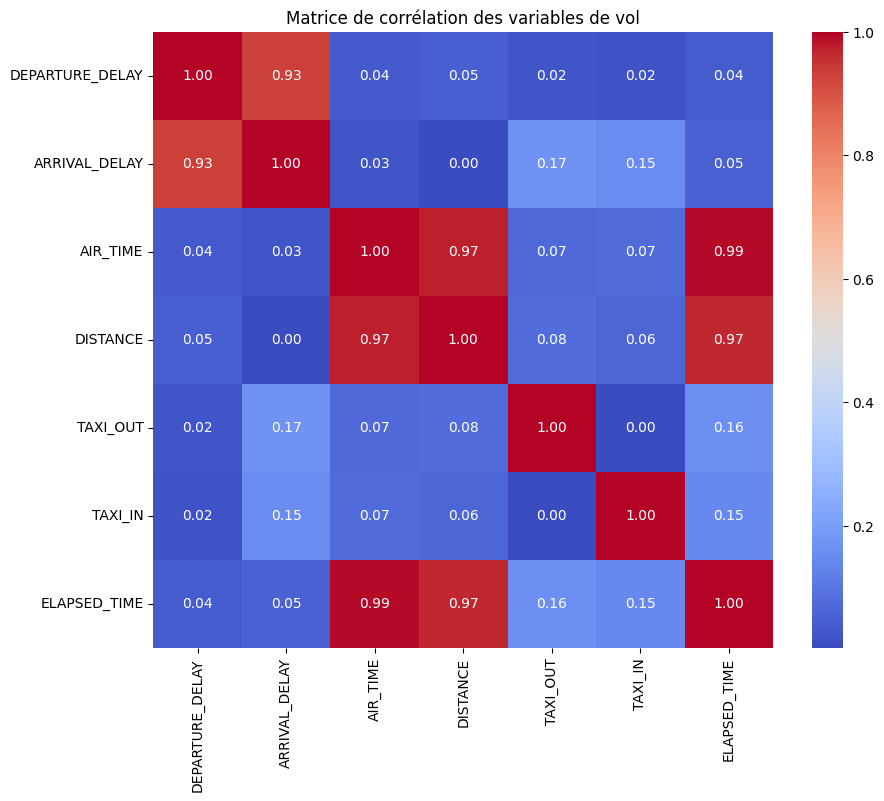

In [87]:
# 1. Sélection des colonnes numériques pertinentes
numeric_cols = [
    "DEPARTURE_DELAY", "ARRIVAL_DELAY", "AIR_TIME", "DISTANCE",
    "TAXI_OUT", "TAXI_IN", "ELAPSED_TIME"
]

# 2. Conversion vers Pandas (avec limitation si nécessaire pour performance)
flights_sample = flights_df.select(numeric_cols).dropna().limit(10000).toPandas()

# 3. Matrice de corrélation
correlation_matrix = flights_sample.corr(numeric_only=True)

# 4. Affichage
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des variables de vol")
plt.show()

# Training

In [ ]:
! pip install tensorflow

In [ ]:
numeric_feature_names = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME','AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

In [ ]:
df_cleaned = flights_df.select(numeric_feature_names).dropna()

MAX_SIZE = 10000

df_limited = df_cleaned.limit(MAX_SIZE)
X = df_limited.toPandas()
y = flights_df.select(['DIVERTED', 'CANCELLED', 'ARRIVAL_DELAY']).dropna().limit(MAX_SIZE).toPandas()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
    unique_values = X[col].unique()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    X_train[col] = X_train[col].map(mapping).fillna(-1).astype(int)
    X_test[col] = X_test[col].map(mapping).fillna(-1).astype(int)

y_train['ARRIVAL_DELAY'] = y_train['ARRIVAL_DELAY'].apply(lambda x: 1 if int(x) > 0 else 0)
y_test['ARRIVAL_DELAY'] = y_test['ARRIVAL_DELAY'].apply(lambda x: 1 if int(x) > 0 else 0)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


In [ ]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')